In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

In [2]:
mut = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [3]:
canc_df = pd.read_csv('../data/external/cancer_mutspec.csv')
canc_df = canc_df[['Mut','MutSpec_ExDloop']]
canc_df = canc_df.rename(columns={"MutSpec_ExDloop":"MutSpec"})
canc_df['Class'] = 'ex_dloop'
canc_df.head()

,Mut,MutSpec,Class
0,A[A>C]A,0.000000,ex_dloop
1,A[A>C]C,0.000783,ex_dloop
2,A[A>C]G,0.000000,ex_dloop
3,A[A>C]T,0.000084,ex_dloop
4,A[A>G]A,0.008273,ex_dloop


In [4]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['cancer']

In [5]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [106]:
n_iter = 1000
n = 0
to_heatmap = []
while n < n_iter:

    for cls1 in cl_vec:
        for cls2 in cl_vec:
            if cls1 == cls2:
                cos192 = 0
            elif cls1 =='cancer':
                df1 = canc_df
                df2_sps = mut[mut['Class'] == cls2]['Species'].sample(n=20, replace=False)
                df2 = calc_mutspec_class(mut[mut['Species'].isin(df2_sps)])
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
            elif cls2 == 'cancer':
                df1_sps = mut[mut['Class'] == cls1]['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(mut[mut['Species'].isin(df1_sps)])
                df2 = canc_df
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
            else:
                df1_sps = mut[mut['Class'] == cls1]['Species'].sample(n=20, replace=False)
                df1 = calc_mutspec_class(mut[mut['Species'].isin(df1_sps)])
                df2_sps = mut[mut['Class'] == cls2]['Species'].sample(n=20, replace=False)
                df2 = calc_mutspec_class(mut[mut['Species'].isin(df2_sps)])
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                
            cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
            to_heatmap.append(cos_res)
    n += 1

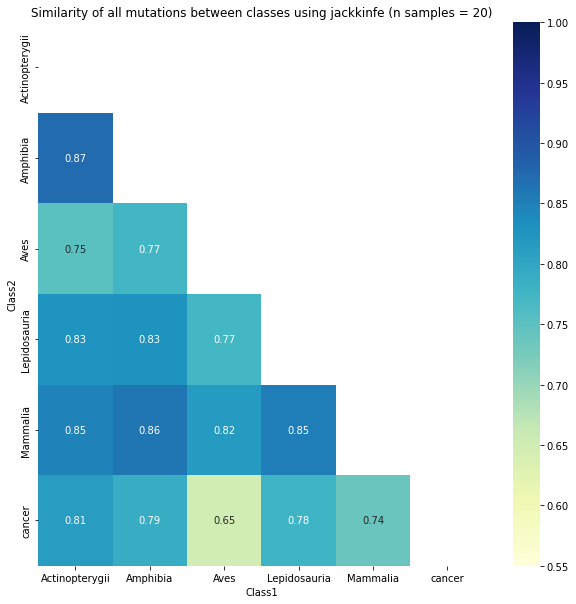

In [116]:
to_heatmap = pd.DataFrame(to_heatmap)
#to_heatmap.groupby(['Class1', 'Class2']).mean().reset_index()
all_heatmap = to_heatmap.groupby(['Class1', 'Class2']).mean().reset_index().pivot('Class2', 'Class1', 'Similarity')
matrix = np.triu(all_heatmap)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(all_heatmap, annot=True, mask=matrix, cmap="YlGnBu", vmin =0.55, vmax=1)
ax.set_title('Similarity of all mutations between classes using jackkinfe (n samples = 20)')
plt.savefig('../pictures/Jackknife_Similarity.pdf', dpi=300)